## Understanding SHAP using hypothecial data

#### Abstract:

The goal of this notebook is to implement and understand the interpretation done by SHapley Additive exPlanations for a hypothetical dataset with 10 samples and 3 independent variables (x,y,z) with a target variabe t.

In this notebook, I am implementing Decision tree regressor model to predict the value of t for an instance x=150, y=75,z=300 (test data) and understand how each feature has impact in the predictions using TreeExplainer.

#### Theory:

Tree SHAP is an algorithm to compute exact SHAP values for Decision Trees based models.
The goal of SHAP is to explain the prediction for any instance xᵢ as a sum of contributions from it’s individual feature values.

The SHAP values are obtained from equation:

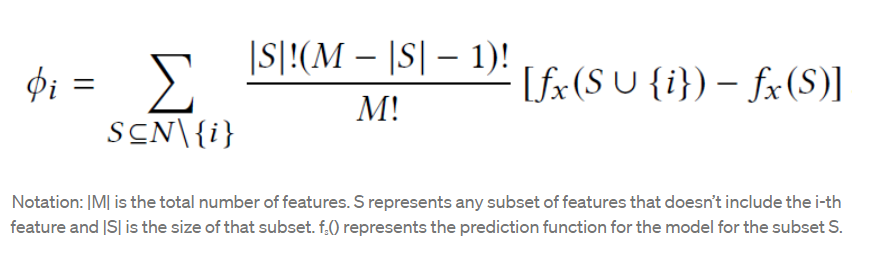

Demonstration of the SHAP values for a simple regression tree to get a better understanding of the algorithm.

In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
%matplotlib inline

Consider a hypothetical dataset of 10 samples with three numeric independent variables (namely: x, y, z) and a target variable t. 

The train data set has x,y and z where

1. In x,the first 5 samples are equal to 206, 6th sample is 194 and the last 4 samples are 6

2. In y,the first 6 samples are random numbers between 100 and 400. The 7th and 8th sample are 299, last two samples are 301

3. In z, all 10 samples are random numbers between 100 and 400

In [2]:
np.random.seed(100)
X_train = pd.DataFrame({'x':[206]*5 + [194] + [6]*4,
                   'y': list(np.random.randint(100, 400, 6)) + [299, 299, 301, 301],
                   'z': list(np.random.randint(100, 400, 10))})
X_train

,x,y,z
0,206,108,114
1,206,380,390
2,206,179,340
3,206,153,380
4,206,166,243
5,194,326,328
6,6,299,158
7,6,299,237
8,6,301,193
9,6,301,186


Target_train contains the target variable 't'

In [3]:
#target_train = pd.Series([10]*5 + [20] + [50]*2 + [30]*2)
target_train = pd.Series([8, 9, 10, 11, 12] + [20] + [45, 55] + [28, 32])
target_train.name = 't'
target_train

0     8
1     9
2    10
3    11
4    12
5    20
6    45
7    55
8    28
9    32
Name: t, dtype: int64

Train and fit the model

In [6]:
tree_model = DecisionTreeRegressor(criterion='mae', max_depth=2, min_samples_leaf=1, min_samples_split=2, random_state = 100)
tree_model.fit(X=X_train, y=target_train)

DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=100)

Tree structure on fitting a regression tree to this dataset is as follows:

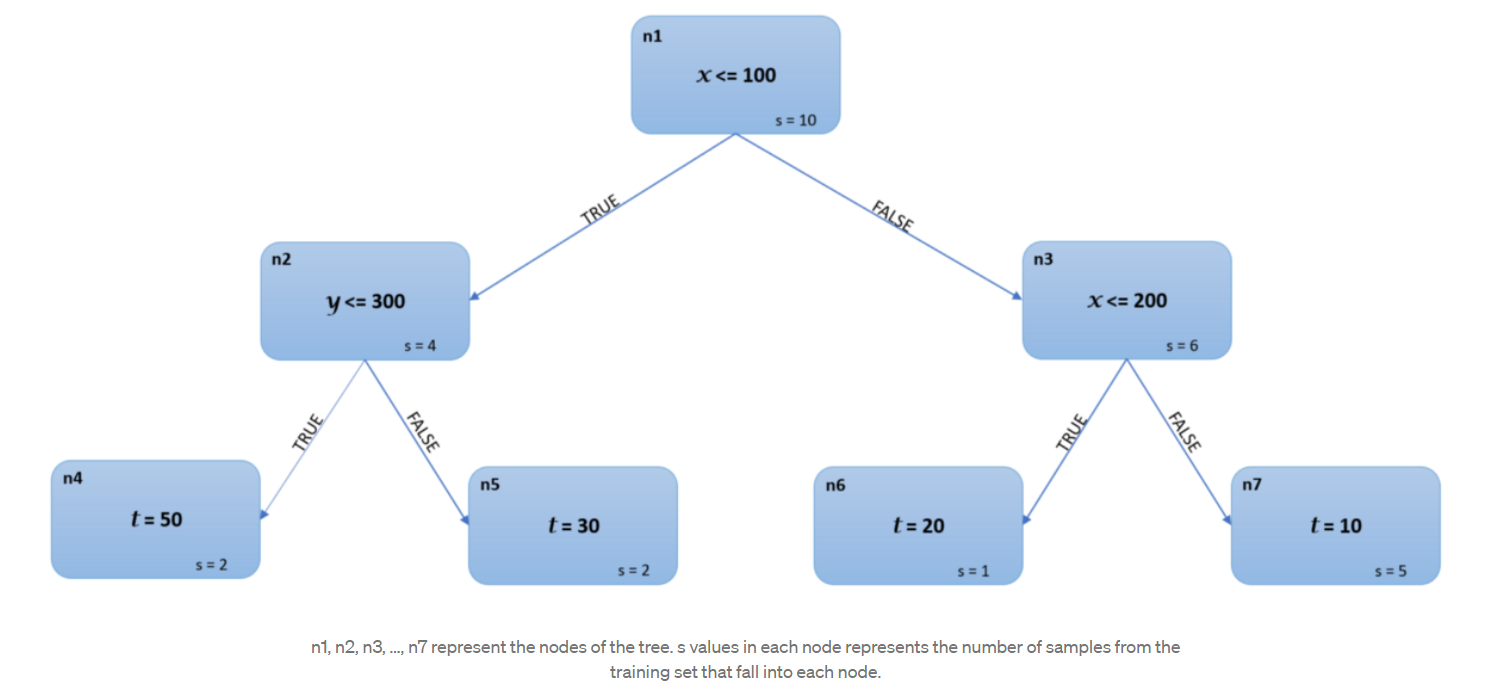

n1, n2, n3,...,n7 represent the nodes of the tree

s values in each node represents the number of samples from the training set that fall into each node

t represents the predictions at the leaf node.

Computing the SHAP values for an instance i given by **[x=150, y=75, z=200].**

The prediction for this instance is **t=20.** 

Note: SHAP is a local feature attribution technique that explains every prediction from the model as a sum of individual feature contributions.




In [8]:
X_test = pd.DataFrame({'x': [150], 'y': [75], 'z': [200]})

**SHAP values are computed by starting with a null model without any independent variables and then computing the average marginal contribution as each variable is added to this model in a sequence; averaged over all possible sequences.**

Since we have 3 independent variables here, we have to consider 3!=6 sequences. 

The 6 sequences that are possible:
1. x > y > z
2. y > z >x
3. x > z > y
4. z > x > y
5. z > y> x
6. y > x> z

SHAP make the assumption that the model prediction for the model with any subset S of independent variables is the expected value of the prediction given the subset xₛ.

**The prediction for the null model ϕ⁰ (also called base value)= mean prediction for the training set = (50x2 + 30x2 + 20x1 + 10x5)/10 = 23**

*Consider the sequence: x > y > z:*

    1)First, the feature x is added to the null model. 
    Note that for the selected instance i, we can compute the exact prediction with just this information as only the variable x is used in the nodes (n1 & n3) leading upto the leaf node n6. Thus the prediction of the model with just the feature x is 20. Therefore the marginal contribution of x in this sequence, ϕˣ¹= 20–23 = -3.

    2)Now adding the feature y to the above model (in step 1). Since adding y does not alter the prediction for the selected instance i, the marginal contribution for y in this sequence, ϕʸ¹ = 20–20 = 0.

    3)Similarly, the marginal contribution for z in this sequence, ϕᶻ¹ = 0.
    
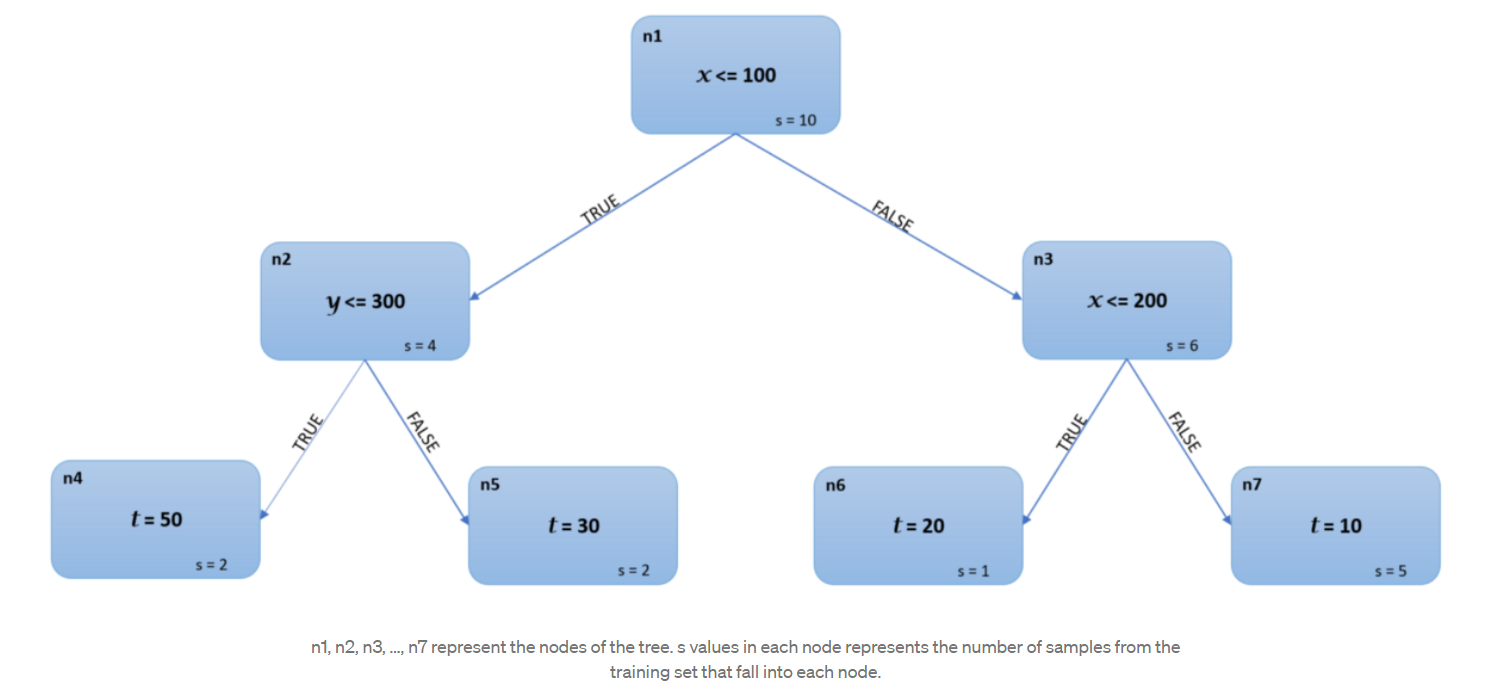

*Consider the sequence y > z >x:*

    1)First, the feature y is added to the null model. The first node n1 uses x as the split variable, since is x is not available yet, the prediction is computed as :

                (4/10)x(prediction from left child node n2) + (6/10)x(prediction from right child n3)

    10, 6 and 4 being number of training samples falling into nodes n1, n2 and n3 respectively.

        i) Prediction from node n2: n2 uses y as the split variable, since y is available (yᵢ = 75 for instance i), the prediction from node n2 = 50.
    
        ii) Prediction from node n3: Again, n3 uses x as the split variable. Therefore, by similar logic, prediction from n3 = (1/6)*20 + (5/6)*10= 70/6.
        
        iii) Therefore, the prediction for the model with just the feature y is (4/10)*50 + (6/10)*(70/6) = 27. Hence, the marginal contribution for y in this sequence, ϕʸ² = 27–23 = 4.
        
    2)Next, we add the feature z to the above model. Since z is not used as a split variable in any of the internal nodes of the tree, adding this feature does not alter the prediction in any way. Thus the marginal contribution for z in this sequence, ϕᶻ² = 0. You may validate this by following this same approach as in step 1.
    
    3)Finally, we add the feature x to the model which gives the prediction as 20. Therefore the marginal contribution of x in this sequence is ϕˣ²=20–27 = -7.



Similarly, computing the marginal contribution of each feature values for remaining sequences:

Sequence x > z > y: ϕˣ³ = -3, ϕʸ³ = 0, ϕᶻ³ = 0

Sequence z > x > y: ϕˣ⁴ = -3, ϕʸ⁴ = 0, ϕᶻ⁴ = 0

Sequence z > y> x: ϕˣ⁵ = -7, ϕʸ⁵ = 4, ϕᶻ⁵ = 0

Sequence y > x> z: ϕˣ⁶ = -7, ϕʸ⁶ = 4, ϕᶻ⁶ = 0

Hence, SHAP values for the instance i are given by:

ϕˣ = (ϕˣ¹ + ϕˣ² + ϕˣ³ + ϕˣ⁴ + ϕˣ⁵ + ϕˣ⁶)/6 = (-3–7–3–3–7–7)/6 = -5

ϕʸ = (ϕʸ¹ + ϕʸ² + ϕʸ³ + ϕʸ⁴ + ϕʸ⁵ + ϕʸ⁶)/6 = (0+4+0+0+4+4)/6 = 2

ϕᶻ = (ϕᶻ¹ + ϕᶻ² + ϕᶻ³ + ϕᶻ⁴ + ϕᶻ⁵ + ϕᶻ⁶)/6 = (0+0+0+0+0+0)/6 = 0



In [9]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-5.,  2.,  0.]])

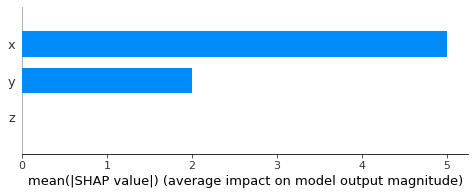

In [11]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The summary plots gives the average impact on the model output.

That's why feature x has mean SHAP value as 5, y has mean SHAP value as 2 and z has mean SHAP value 0 respectively.

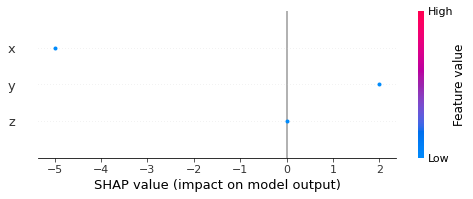

In [12]:
shap.summary_plot(shap_values, X_test)

A low feature value for x has negative impact on the data.
A low feature value for y has positive impact on the data whereas low feature value has no impact on the data

In [10]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

**The scale here represents a visualization of a small interval around the output and base values.**

And explanation for the prediction for instance i [x=150, y=75, z=300] (20) = ϕ⁰ + ϕˣ + ϕʸ + ϕᶻ = 23 + (-5) + 2 + 0 = 20

**“The base value of the prediction in the absence of any information on independent variables is 23; knowing x=150 decreased the prediction by 5 and knowing y = 75 increased the prediction by 2 giving a final prediction of 20. Knowing z = 300 had no impact on the model prediction.”**

SHAP provides a good pictorial representation of this explanation as below. Blue color indicates that x value (=150) decreased the prediction and red color indicates that y value(=75) increased the prediction.

#### Conclusion

SHAP values are calculated based on n! sequences where n is the number of features, in this case 3! = 6 sequences.

Marginal contribution of each feature in n! sequences are calculated and average of the marginal contribution gives the SHAP values for each feature.

### References

1. https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b